# Are brains like faces?


Copyright 2019 Allen Downey

[MIT License](https://opensource.org/licenses/MIT)

In [62]:
%matplotlib inline
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import thinkstats2
import thinkplot

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.models
import keras.layers

import pickle

from warnings import simplefilter
simplefilter('ignore', FutureWarning)

Load the NKI SBA volume data, since it seems to have the most features with the highest Cohen effects.

In [63]:
df = pd.read_excel('brain_mosaic_data/NKI_SBA_Volume.xlsx')
df.head()

,bio_sex,age,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,...,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume
0,2,41,5443,408,14526,47120,6506,2944,4535,1828,...,1151,13009,16499,10019,9201,7703,783,1945,923,6297
1,2,52,3228,309,13065,48090,6942,2918,5000,1734,...,1308,13780,18011,11602,12166,10272,747,1921,790,5537
2,2,54,5642,95,9687,38398,6385,2892,4351,1051,...,1903,13247,17477,10010,8808,8331,1193,2043,484,6033
3,2,56,4959,231,11442,41214,6195,3604,5135,1592,...,1753,12481,17378,9682,10091,9396,802,2336,799,6159
4,2,31,6664,161,12059,44711,6613,2981,4558,1462,...,1396,11924,21013,12134,10928,10362,699,2549,911,5853


Make the column names play nicely with StatsModels.

In [64]:
def clean_name(name):
    """Make column names play nicely with StatsModels.
    """
    name = name.replace('-', '_').lower()
    d = {'3rd_ventricle':'third_ventricle', '4th_ventricle':'fourth_ventricle'}
    return d.get(name, name)

In [65]:
columns = [clean_name(name) for name in df.columns]
df.columns = columns
df.head()

,bio_sex,age,left_lateral_ventricle,left_inf_lat_vent,left_cerebellum_white_matter,left_cerebellum_cortex,left_thalamus_proper,left_caudate,left_putamen,left_pallidum,...,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_frontalpole_volume,rh_temporalpole_volume,rh_transversetemporal_volume,rh_insula_volume
0,2,41,5443,408,14526,47120,6506,2944,4535,1828,...,1151,13009,16499,10019,9201,7703,783,1945,923,6297
1,2,52,3228,309,13065,48090,6942,2918,5000,1734,...,1308,13780,18011,11602,12166,10272,747,1921,790,5537
2,2,54,5642,95,9687,38398,6385,2892,4351,1051,...,1903,13247,17477,10010,8808,8331,1193,2043,484,6033
3,2,56,4959,231,11442,41214,6195,3604,5135,1592,...,1753,12481,17378,9682,10091,9396,802,2336,799,6159
4,2,31,6664,161,12059,44711,6613,2981,4558,1462,...,1396,11924,21013,12134,10928,10362,699,2549,911,5853


Make a binary variable for StatsModels.

In [66]:
df['male'] = (df['bio_sex'] == 1).astype(int)
df['male'].mean()

0.3786764705882353

Select the volumetric features (I don't know what the other features are).

In [67]:
features = [name for name in df.columns if name.endswith('volume')]
len(features)

68

Compute total volume.

In [68]:
df['total_volume'] = df[features].sum(axis=1)
df['total_volume'].describe()

count       272.000000
mean     455371.117647
std       56890.820457
min      336198.000000
25%      416941.500000
50%      450121.000000
75%      489089.250000
max      684464.000000
Name: total_volume, dtype: float64

Make sure the new variables are on the feature list.

In [69]:
features = [name for name in df.columns if name.endswith('volume')]
len(features)

69

Distribution of volumes.

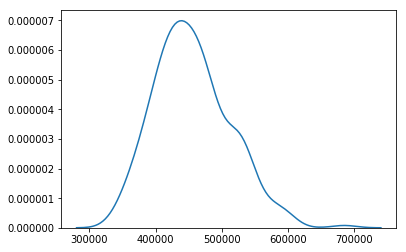

In [70]:
var = 'total_volume'
sns.kdeplot(df[var].values);

Distributions of total volume for male and female subjects.  As expected, men have bigger brains.

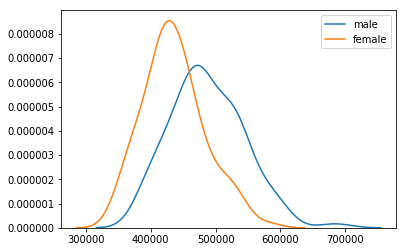

In [71]:
df['bio_sex'].replace(1, 0, inplace=True)
df['bio_sex'].replace(2, 1, inplace=True)

male = df['bio_sex'] == 0
female = df['bio_sex'] == 1

sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');

## Cohen effect size

Let's look for the features that show the biggest difference between men and women.

In [72]:
def cohen_effect_size(group1, group2):
    """Compute Cohen's effect size (d).

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

In [73]:
def compute_cohen_effect(df, features):
    res = pd.Series()

    grouped = df.groupby('male')
    for var in features:
        groups = grouped[var]
        male = groups.get_group(1)
        female = groups.get_group(0)
        d = cohen_effect_size(male, female)
        res[var] = d
        
    return res

Here are the top features by Cohen effect size.  The biggest difference is in total volume.  I suspect that the other top candidates are strongly correlated with total volume.

In [74]:
num_features = 12

res = compute_cohen_effect(df, features)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

total_volume                      0.998091
rh_superiorfrontal_volume         0.970546
rh_inferiortemporal_volume        0.964111
rh_lateraloccipital_volume        0.960110
rh_precuneus_volume               0.958064
lh_middletemporal_volume          0.953209
lh_superiorfrontal_volume         0.941572
lh_medialorbitofrontal_volume     0.937211
rh_rostralmiddlefrontal_volume    0.927699
lh_inferiortemporal_volume        0.909025
rh_fusiform_volume                0.890256
rh_lateralorbitofrontal_volume    0.874188
dtype: float64

In [84]:
def divide_by_vol(columns):
    for column in columns:
        df[column + '_norm'] = df[column]/df['total_volume']
        
columns = [name for name in df.columns if name.endswith('volume')]
divide_by_vol(columns)

In [85]:
df.drop('total_volume_norm', axis = 1)
features_norm = [name for name in df.columns if name.endswith('norm')]
len(features)

69

In [88]:
num_features = 12

res = compute_cohen_effect(df, features_norm)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

/home/eprice/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


lh_middletemporal_volume_norm          0.416500
rh_inferiortemporal_volume_norm        0.378245
lh_rostralmiddlefrontal_volume_norm    0.337220
rh_rostralmiddlefrontal_volume_norm    0.305688
rh_middletemporal_volume_norm          0.300476
lh_inferiortemporal_volume_norm        0.278646
lh_medialorbitofrontal_volume_norm     0.259600
rh_precuneus_volume_norm               0.249023
lh_parsorbitalis_volume_norm           0.234720
lh_supramarginal_volume_norm           0.205109
rh_parsorbitalis_volume_norm           0.189739
rh_inferiorparietal_volume_norm        0.184604
dtype: float64

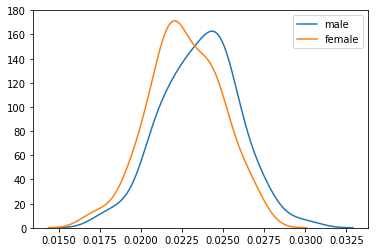

In [89]:
var = 'lh_middletemporal_volume_norm'
# sns.kdeplot(df[var].values);

sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');

R^2: 0.6707317073170732
Root Mean Squared Error: 0.5738190417570045
0.7215354586857515
[[15 14]
 [13 40]]


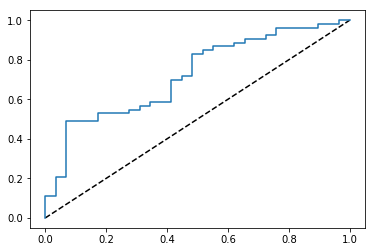

In [94]:
y = df['bio_sex']
X = df.drop(list(set(df.columns).difference(set(features))), axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

R^2: 0.6463414634146342
Root Mean Squared Error: 0.59469196781642
0.7807417046193884
[[ 0 29]
 [ 0 53]]


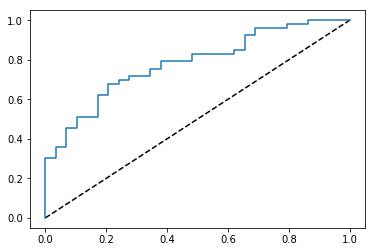

In [93]:
y = df['bio_sex']
X = df.drop(list(set(df.columns).difference(set(features_norm))), axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))